# Hashtag and Semantic Networks

In this notebook we generate some different bipartite networks on the subset of Bushfire tweets. We define actor nodes as being either Party or MP and document nodes as being either hashtags or words (unigrams).

In [3]:
#Necessary imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import tweepy
from datetime import date
import pickle 
import time
from textnets import Corpus, Textnet
import matplotlib.pyplot as plt

## Preparing the Network

In [4]:
network_df = pd.read_csv("data/bushfire_subset.csv", index_col=0)

In [5]:
network_df["hashtags"] = network_df["hashtags"].apply(eval).apply(' '.join)
network_df["hashtags"] = network_df["hashtags"].str.split()
network_df["hashashtag"] = network_df["hashtags"].apply(lambda x: 1 if len(x) > 0 else 0)
hashtag_df = network_df.loc[network_df["hashashtag"] == 1].reset_index(drop = True)
hashtag_df = hashtag_df.explode("hashtags")
hashtag_df["party2"] = hashtag_df["party"]

## MP-Hashtag Network

In [276]:
#[w[1] for w in Counter(hashtags).items()]

In [289]:
hashtags = hashtag_df["hashtags"].tolist()
hashtags = [w[0] for w in Counter(hashtags).items() if w[1] >= 2]
mp_hashtag_df["top_hashtags"] = mp_hashtag_df["hashtags"].apply(lambda x: x if x in hashtags else np.nan)

In [290]:
#Prepare data for MP-Hashtag Network
#mp_hashtag_df = hashtag_df.set_index("name")



mp_hashtag_corpus = Corpus.from_df(mp_hashtag_df, doc_col='top_hashtags', lang='en')
tn_mp_hashtag = Textnet(mp_hashtag_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), 
                        min_docs=1, doc_attrs=mp_hashtag_df[['party']].to_dict())

/home/matiasp/.local/lib/python3.8/site-packages/textnets/corpus.py:65: UserWarning: Dropping 251 empty document(s).
  warn(f"Dropping {missings} empty document(s).")


In [291]:
mp_hashtag_plot = tn_mp_hashtag.plot(label_term_nodes=True,
                                    label_doc_nodes=True,
                                    vertex_label_size = 6,
                                    vertex_color=['gray' if v['party'] is None 
                                                  else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                  else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                  else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                  else ('gold' if v['party'] == 'The Nationals' 
                                                  else ('darkorange' if v['party'] == 'Center Alliance' 
                                                  else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                  else  'purple'))))))
                                                  for v in tn_mp_hashtag.vs],
                                    vertex_shape=['none' if v['party'] is None 
                                                  else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                  else 'triangle-down'
                                                  for v in tn_mp_hashtag.vs],
                                    scale_nodes_by = 'degree')

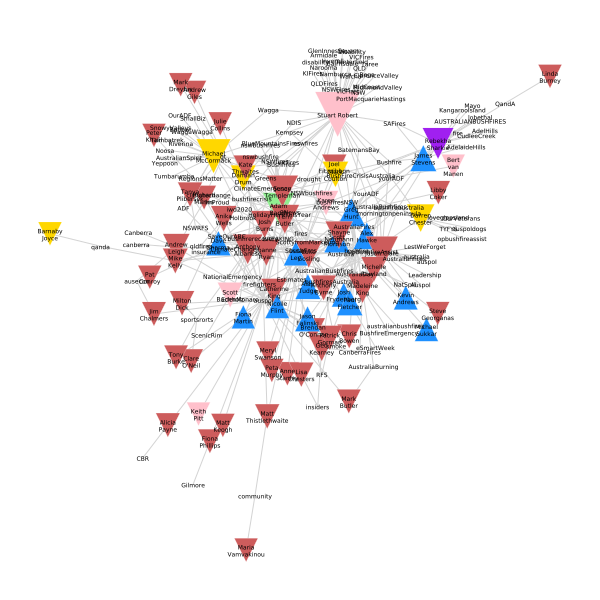

In [292]:
mp_hashtag_plot

In [ ]:
print(tn.degree.sort_values(ascending=False)[:20].to_markdown())

## Party-Hashtag Network

In [295]:
#Prepare data for Party-Hashtag Network
party_hashtag_df = mp_hashtag_df.set_index("party2")
party_hashtag_corpus = Corpus.from_df(party_hashtag_df, doc_col='top_hashtags', lang='en')
tn_party_hashtag = Textnet(party_hashtag_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), min_docs=1, doc_attrs=party_hashtag_df[['party']].to_dict())

/home/matiasp/.local/lib/python3.8/site-packages/textnets/corpus.py:65: UserWarning: Dropping 251 empty document(s).
  warn(f"Dropping {missings} empty document(s).")


In [299]:
party_hashtag_plot = tn_party_hashtag.plot(label_term_nodes=True,
                                            label_doc_nodes=True,
                                            vertex_label_size=5,
                                            vertex_color=['lightgray' if v['party'] is None 
                                                          else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                          else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                          else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                          else ('gold' if v['party'] == 'The Nationals' 
                                                          else ('darkorange' if v['party'] == 'Center Alliance' 
                                                          else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                          else  'purple'))))))
                                                          for v in tn_party_hashtag.vs],
                                            vertex_shape=['none' if v['party'] is None 
                                                          else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                          else 'triangle-down'
                                                          for v in tn_party_hashtag.vs],
                                            scale_nodes_by = 'degree',
                                            dpi = 600)

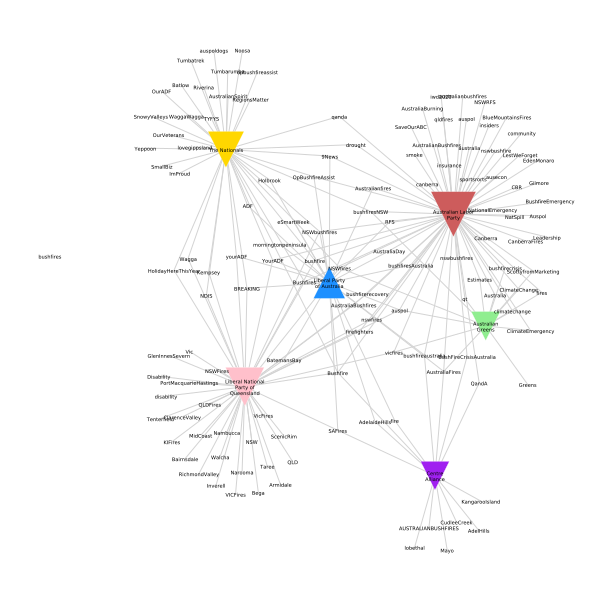

In [300]:
party_hashtag_plot#.save("hashtagplot.svg")

## Party-Semantic Network

In [330]:
network_df["party2"] = network_df["party"]
party_semantic_df = party_semantic_df.groupby('party', group_keys=False).apply(lambda x: x.sample(min(len(x), 300)))
party_semantic_df = network_df.set_index("party2")

In [331]:
vocab = ' '.join(party_semantic_df["final_text"].to_list()).split()
top_w = [w[0] for w in Counter(vocab).items() if w[1] >= 30]

In [332]:
party_semantic_df["top_words"] = party_semantic_df["final_text"].apply(lambda txt: ' '.join([w for w in txt.split() if w in top_w]))

In [333]:
party_semantic_corpus = Corpus.from_df(party_semantic_df, doc_col='top_words', lang='en')

In [334]:
tn_party_semantic = Textnet(party_semantic_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                            remove_numbers = False, remove_stop_words = False,
                                                            remove_urls = False), min_docs=1, doc_attrs=party_semantic_df[['party']].to_dict())

In [335]:
plot_party_semantic = tn_party_semantic.plot(label_term_nodes=True,
                                             label_doc_nodes=True,
                                             vertex_label_size=4,
                                             vertex_color=['gray' if v['party'] is None 
                                                              else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                              else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                              else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                              else ('gold' if v['party'] == 'The Nationals' 
                                                              else ('darkorange' if v['party'] == 'Center Alliance' 
                                                              else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                              else  'purple'))))))
                                                              for v in tn_party_semantic.vs],
                                               vertex_shape=['none' if v['party'] is None 
                                                              else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                              else 'triangle-down'
                                                              for v in tn_party_semantic.vs])

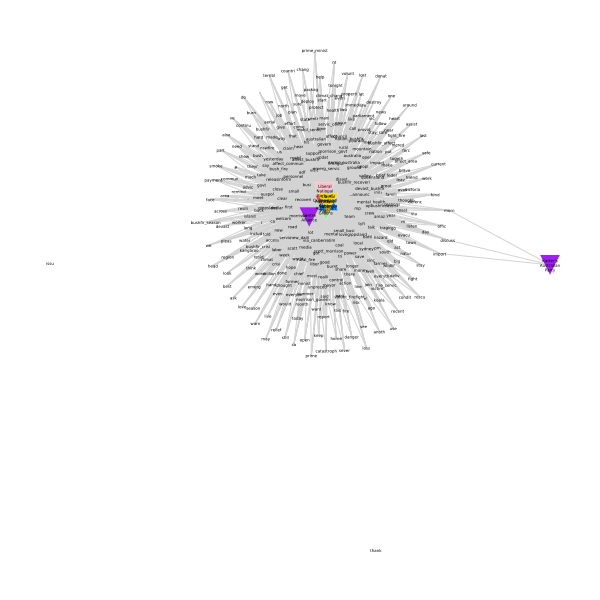

In [336]:
plot_party_semantic

In [252]:
words = tn_party_semantic.project(node_type='term')
#words.plot(label_nodes=True,
#           show_clusters=False)

## MP-Semantic Network

In [ ]:
mp_semantic_df = network_df.set_index("name")
mp_semantic_corpus = Corpus.from_df(mp_semantic_df, doc_col='final_text', lang='en')
tn_mp_semantic = Textnet(mp_semantic_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), min_docs=1, doc_attrs=mp_semantic_df[['party']].to_dict())
mps = tn_mp_semantic.project(node_type='doc')
#words = tn.project(node_type='term')

In [ ]:
mp_semantic_plot = mps.plot(label_nodes=True,
                    vertex_label_size=5,
                    scale_nodes_by = "degree",
                    vertex_color=['gray' if v['party'] is None 
                                  else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                  else ('indianred' if v['party'] == 'Australian Labor Party' 
                                  else ('lightgreen' if v['party'] == 'Australian Greens' 
                                  else ('gold' if v['party'] == 'The Nationals' 
                                  else ('darkorange' if v['party'] == 'Center Alliance' 
                                  else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                  else  'purple'))))))
                                  for v in tn_mp_semantic.vs],
                    vertex_shape=['circle' if v['party'] is None 
                                  else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                  else 'triangle-down'
                                  for v in tn_mp_semantic.vs],)

In [ ]:
mp_semantic_plot

In [ ]:
plot_mp_semantic = tn_mp_semantic.plot(label_term_nodes=True,
                                      label_doc_nodes=True,
                                      vertex_label_size=4,
                                      alpha = 0.05,
                                      vertex_color=['gray' if v['party'] is None 
                                                      else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                      else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                      else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                      else ('gold' if v['party'] == 'The Nationals' 
                                                      else ('darkorange' if v['party'] == 'Center Alliance' 
                                                      else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                      else  'purple'))))))
                                                      for v in tn_mp_semantic.vs],
                                       vertex_shape=['none' if v['party'] is None 
                                                      else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                      else 'triangle-down'
                                                      for v in tn_mp_semantic.vs])

In [ ]:
plot_mp_semantic

## Temporal Hashtag Network using pathpy


In [ ]:
import pathpy as pp

In [ ]:
network_df['start_date'] = pd.Timestamp('2019-06-03')
network_df["t"] = (pd.to_datetime(network_df["created_at"]) - pd.to_datetime(network_df["start_date"])).dt.days

In [ ]:
pp_tuple = list(zip(network_df["name"], network_df["hashtags"], network_df["t"]))

In [ ]:
t = pp.TemporalNetwork()
for link in pp_tuple:
    t.add_edge(link[0], link[1], link[2])